## Latest Version of Post_processing

It is for data saved at different times.

In [1]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LsqFit
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf

nthreads = 1


In [2]:
e = -1
m = 1

1

In [3]:
include("aux_functions_vlasov.jl")

In [4]:
#file_name = "Results/ltd_landau_try2000_401_alp3_n2_Th3.jld2"
#file_name = "Results/ltd_landau_undamped3522_401_alp3_n2_Th3.jld2"
#file_name = "Results/lltd_landau_undamped3522_401_alp3_n2_Th3.jld2"
file_name = "Results/ltd_landau_damped930_401_alp3_n15_Th3.jld2"

"Results/ltd_landau_damped930_401_alp3_n15_Th3.jld2"

In [137]:
data = load(file_name);
run_name = data["run_name"]
@show (m, θ, α, k) = data["p_Ini"] # if landau
#@show (m, θ, α, k, vel) = data["p_Ini"] # if two streams
@show (Nx, dx, Np, dp) = data["par_grid"]
@show (t_i, t_f, M, M_g, dt) = data["par_evolv"]

Lx = (Nx-1)*dx
Lp = (Np-1)*dp/2
κ = 2π/Lx

@show Lx, Lp, κ

x = [(i-1)*dx for i in 1:Nx]
p = [get_p(j,dp,Np)/m for j ∈ 1:Np]
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];

dT = dt * (M-1) / (M_g-1)


#M_g = 501 



v = zeros(Nx*(Np+1),M_g)

for j in 1:M_g
    tiempo = @sprintf("%05d", j)
    v[:,j] = data["u/u_$tiempo"]
end

k*sqrt(θ)
1 + 3θ/2*k^2

(m, θ, α, k) = data["p_Ini"] = (1, 0.001, 0.001, 12.642223958107818)
(Nx, dx, Np, dp) = data["par_grid"] = (930, 0.008016129032258065, 401, 0.005)
(t_i, t_f, M, M_g, dt) = data["par_evolv"] = (0.0, 20.0, 2001, 501, 0.01)
(Lx, Lp, κ) = (7.446983870967742, 1.0, 0.8437221586681214)


1.239738739910433

In [6]:
plots = true
animation = true

true

In [7]:
if plots 
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:5:(M_g)
        plt = plot!(1e2*v[Nx*Np+1:end,j].+ofset*j)
    end
    plt
    png("electric_field_" * run_name)
end

In [8]:
if plots
    F = reshape(v[1:Nx*Np,:],(Nx,Np,M_g));

    #plot(F[Nx÷2,:,1])
    #plot!(F[Nx÷2,:,501])
    #plot_matrix(F[1:2:end,1:2:end,1]) #sparse version
    plot_matrix(F[:,:,1])
    png("initial_dist_" * run_name)
end

In [9]:
if plots
    plot_matrix(F[:,:,end], title="t=$t_f")
    png("final_dist_" * run_name)
end

In [10]:
if plots
    heatmap(F[:,:,end],
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function at t = $(t_f)"
    )

    png("final_conf_heat_" * run_name)
end

┌ Info: Saved animation to 
│   fn = /home/oreula/Julia/Vlasov/Distr_funct_cutltd_landau_damped930_401_alp3_n15_Th3.gif
└ @ Plots /home/oreula/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/oreula/Julia/Vlasov/Distr_funct_cutltd_landau_damped930_401_alp3_n15_Th3.gif")
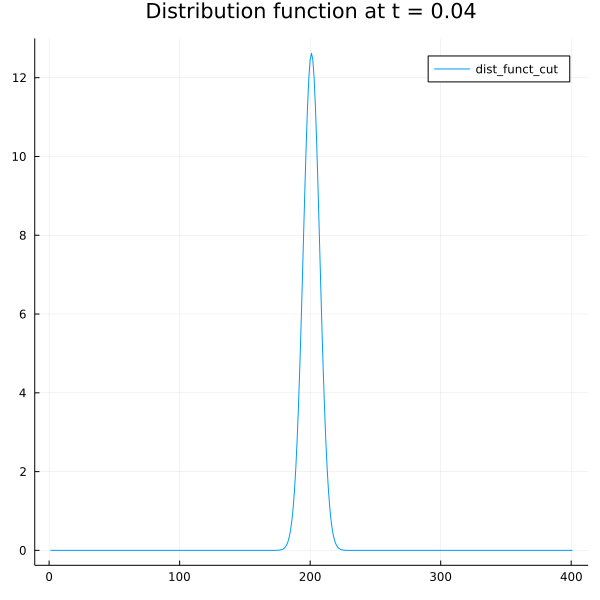

In [11]:
if animation
    anim = @animate for j = 1:5:M_g
        plot(F[Nx÷8,:,j]
        ,title = "Distribution function at t = $(dT*j)"
        ,label = "dist_funct_cut"
    )
    end

     
    gif(anim, "Distr_funct_cut"  * run_name * ".gif", fps = 5)
end

┌ Info: Saved animation to 
│   fn = /home/oreula/Julia/Vlasov/Distr_funct_ltd_landau_damped930_401_alp3_n15_Th3.gif
└ @ Plots /home/oreula/.julia/packages/Plots/LI4FE/src/animation.jl:114


Plots.AnimatedGif("/home/oreula/Julia/Vlasov/Distr_funct_ltd_landau_damped930_401_alp3_n15_Th3.gif")
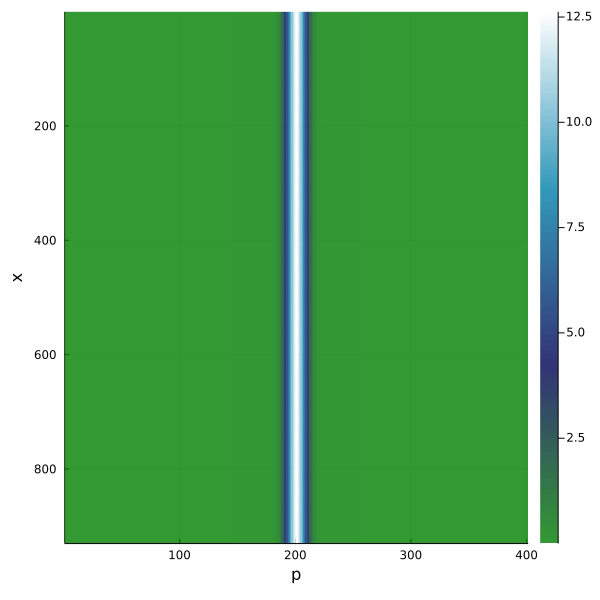

In [12]:
if animation
    anim = @animate for j = 1:50:M_g
        heatmap(F[:,:,j]
        #,c = cgrad([:blue,:white,:red])
        ,fc = :ocean
        ,linealpha = 0.8, fillalpha=0.8
        ,yflip = true
        ,xlabel = "p", ylabel = "x"
        #,title = "Distribution function at t = $(dT*j)"
    )
    end

     
    gif(anim, "Distr_funct_"  * run_name * ".gif", fps = 5)
end

In [13]:
ρ_f = zeros(Nx)
E_f = zeros(Nx)
E_i = v[Nx*Np+1:end,1]
ϕ_f = zeros(Nx)
S_f = zeros(Nx)

j = 90

get_density!(v[:,j], ρ_f, (Nx, dx, Np, dp, m, e))
Q = get_total_charge(ρ_f, (Nx, dx))
println("n0 = $(Q/Lx)")
get_ϕ!(ϕ_f, ρ_f .+ Q/e/Lx, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[Nx*Np+1:end,j], label="E_final"
    )

    png("Efield_th$(nthreads())_" * run_name)
end


n0 = -1.001076426264803


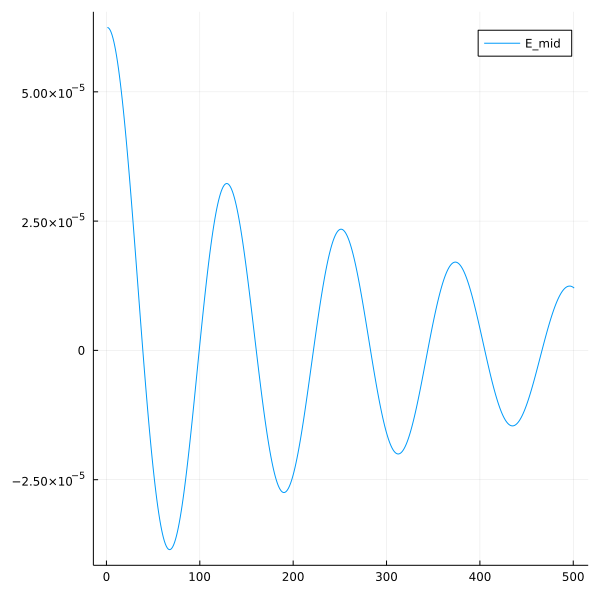

In [14]:
plot(v[Nx*Np+Nx÷8,:], label="E_mid")

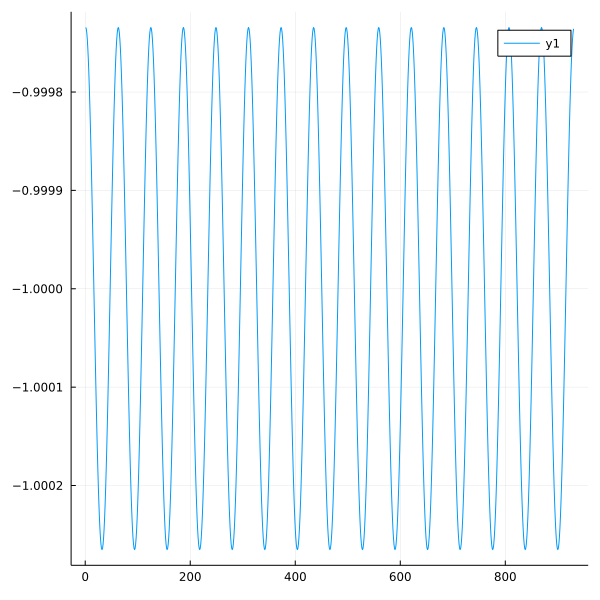

In [15]:
plot(ρ_f)

In [16]:
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
Q_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
E_K = zeros(Nx)
P = zeros(Nx)
ρ = zeros(Nx)
S = zeros(Nx)

for j in 1:M_g
    Energy_K[j]  = sum(get_K_energy!(v[:,j],E_K,(Nx, dx, Np, dp)))*dx
    Energy_E[j]  = get_E_energy(v[:,j],(Nx, dx, Np, dp))
    EField_T[j] = sum(v[Nx*Np+1:end,j])*dx
    p_T[j] = sum(get_momentum!(v[:,j],P,(Nx, dx, Np, dp)))*dx

    get_density!(v[:,j], ρ, (Nx, dx, Np, dp, m, e))
    get_current!(v[:,j], S, (Nx, dx, Np, dp, v, m, e))
    Q_T[j] = get_total_charge(ρ,(Nx, dx))
    S_T[j] = sum(S)/Nx/Q_T[j]
end

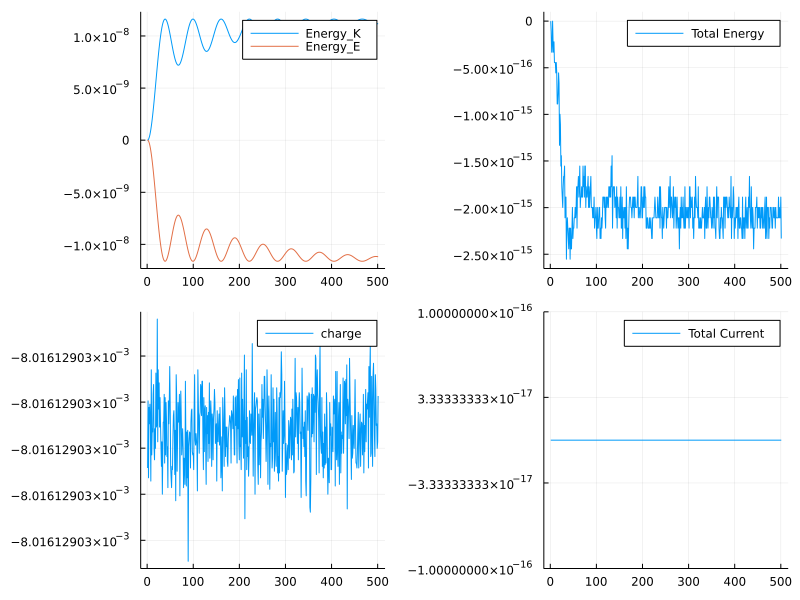

GKS: Possible loss of precision in routine SET_WINDOW


In [17]:

if plots 
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T .- e*Lx, label="charge")
    plot!(subplot=4, S_T, label="Total Current")

    #png("total_conf_" * run_name)
end

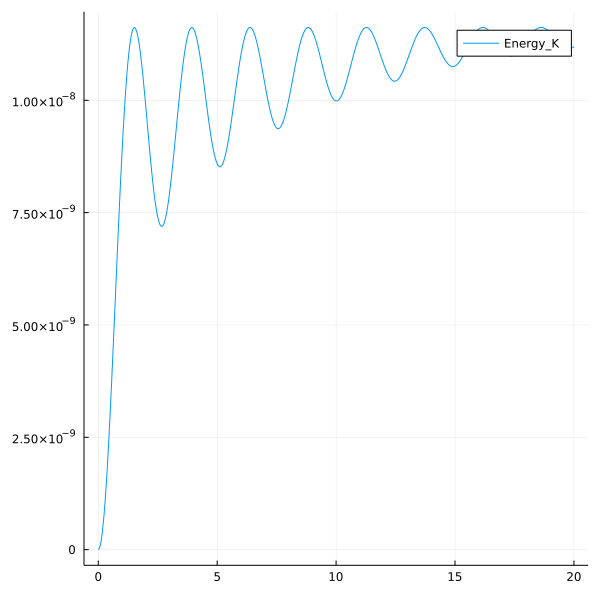

In [18]:
t_series = [dt*(i-1)*((M-1)÷(M_g-1)) for i in 1:M_g];
#Plots.scatter(t_series,(Energy_K .- Energy_K[1]), label="Energy_K")
plot(t_series,(Energy_K .- Energy_K[1]), label="Energy_K")

In [192]:
p0 = [1.01944*10^(-4); 1.24; 0.4 ; 1.9*10^(-5); 1.130; 0.01; 0.0]
@. model(x, p) = (p[1]*cos(x*p[2])*exp(-x*p[3]) + p[4]*cos(x*p[5] + p[7]) * exp(-x*p[6]))^2#*cos(x*p[5] + p[6])


model (generic function with 1 method)

In [193]:
t_series = [dt*(i-1)*((M-1)÷(M_g-1)) for i in 1:M_g];
fit = curve_fit(model, t_series, Energy_E, p0);
fit.param

7-element Vector{Float64}:
 0.00012238032138981312
 1.239999996704613
 0.3999999924894552
 1.8994634786151118e-5
 1.13
 0.01
 0.0

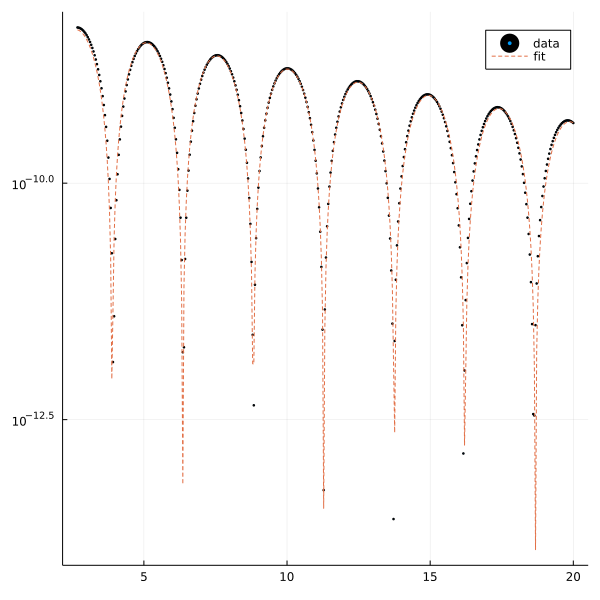

In [284]:
Plots.scatter(t_series, Energy_E,label="data",markersize=1)
#plot!(t_series, model(t_series, fit.param),label="fit")

#a = [1.0744*10^(-4); 1.; 0.1 ; 0.02]

#plot!(t_series, model(t_series,a), ls=:dash ,label="fit")



## Finally it is working!

Fit for undamped **ltd_landau_try2000_401_alp3_n2_Th3.jld2** with parameters: 

(Nx, dx, Np, dp) = data["par_grid"] = (2000, 0.1, 401, 0.005)

(t_i, t_f, M, M_g, dt) = data["par_evolv"] = (0.0, 20.0, 2001, 501, 0.01)

(Lx, Lp, κ) = (199.9, 1.0, 0.03143164235707647)



$p1 = 0.012664650807392602 $, $p2 = 0.9992219211655119$ for $E_E(t) = p1\; cos(p2*t)^2$


Fit for undamped **ltd_landau_undamped3522_401_alp3_n2_Th3.jld2** with parameters: 

(Nx, dx, Np, dp) = data["par_grid"] = (3522, 0.011282793867120954, 401, 0.005)

(t_i, t_f, M, M_g, dt) = data["par_evolv"] = (0.0, 20.0, 2001, 501, 0.01)

(Lx, Lp, κ) = (39.72671720613288, 1.0, 0.15816019417304403)

$p1 = 9.930651342293839e-5$, $p2 =  0.9993996803870632$

Expected value: $\omega = 1.0001500026654444$

Con los parámetros tales que t_f = 200, M = 20001 (resto igual) nos da:

$p1 = 9.930331121005456e-5$, $p2 =  0.9993994628658155$

### The damped case:

The parámeters are:

(m, θ, α, k) = data["p_Ini"] = (1, 0.001, 0.001, 12.642223958107818)

(Nx, dx, Np, dp) = data["par_grid"] = (930, 0.008016129032258065, 401, 0.005)

(t_i, t_f, M, M_g, dt) = data["par_evolv"] = (0.0, 20.0, 2001, 501, 0.01)

(Lx, Lp, κ) = (7.446983870967742, 1.0, 0.8437221586681214)

In this case the frequency should be: $\omega = (1+3*θ*k^2/2) = 1.239738739910433$

**But** according to the paper is: $\omega = 1.28506$ **???**

And the decay should be: $\gamma = −0.06613$

We get: 

$\omega_{sim} = 1.2749$ **very high! Or very low... See in the last plot that it is not possible to fit data with the larger or lower values**

$\gamma_{sim} = -0.0649$

We first look at the Fourier components

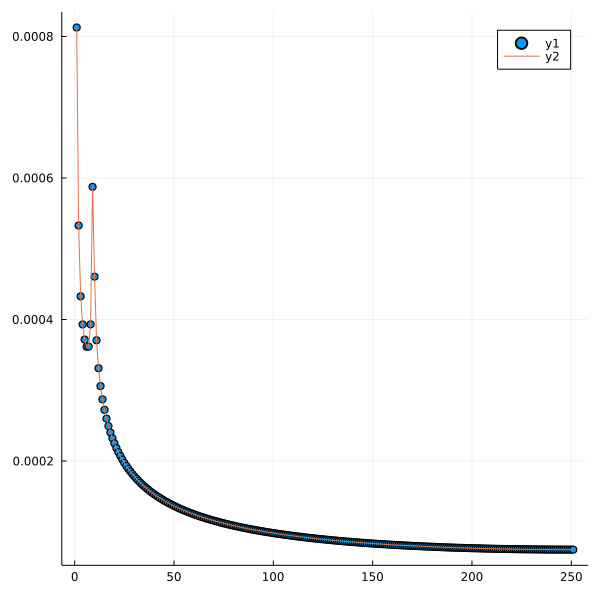

In [292]:
Plots.scatter(sqrt.(abs.(rfft(Energy_E))))
plot!(sqrt.(abs.(rfft(Energy_E))))

So, there is a continuum plus a clear signal at a given frequency.

We let some time go throught and then fit the rest of the curve (manually).

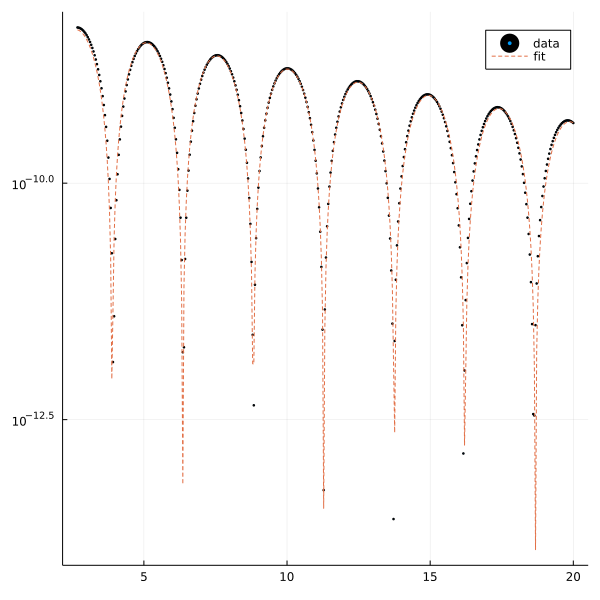

In [295]:
@. model_2(x,p) = (p[1]*cos(p[2]*x + p[3])*exp(-x*p[4]))^2
p2=[7.7*10^(-5); 1.275; -0.25; 0.065]
ini = 68
t_s = t_series[ini:end]
Plots.scatter(t_s, Energy_E[ini:end],label="data",markersize=1)
plot!(t_s,model_2(t_s,p2), ls=:dash ,label="fit", yscale=:log10)
#png("damped_case_fit_1")

To see the differences if we fit the whole interval we do the fitting with the whole interval:

In [296]:
fit_2 = curve_fit(model_2, t_series, Energy_E, p2);
fit_2.param

4-element Vector{Float64}:
  8.950197737914932e-5
  1.2749999962310017
 -0.25000000255632454
  0.06500003359666315

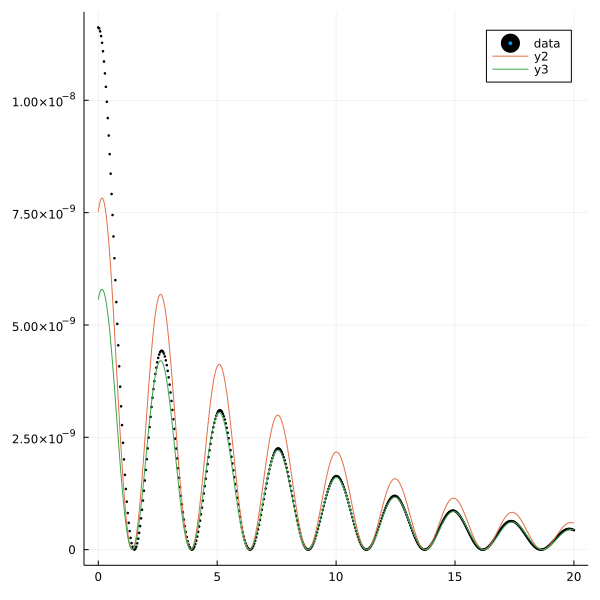

In [290]:
Plots.scatter(t_series, Energy_E,label="data",markersize=1)
plot!(t_series,model_2(t_series, fit_2.param))
plot!(t_series,model_2(t_series, p2))

Finally we perform the fitting starting at around t=5

In [297]:
fit_2_c = curve_fit(model_2, t_series[80:end], Energy_E[80:end], p2);
fit_2_c.param

4-element Vector{Float64}:
  7.702939111052409e-5
  1.2749999999919588
 -0.2500000000024768
  0.06499999998552478

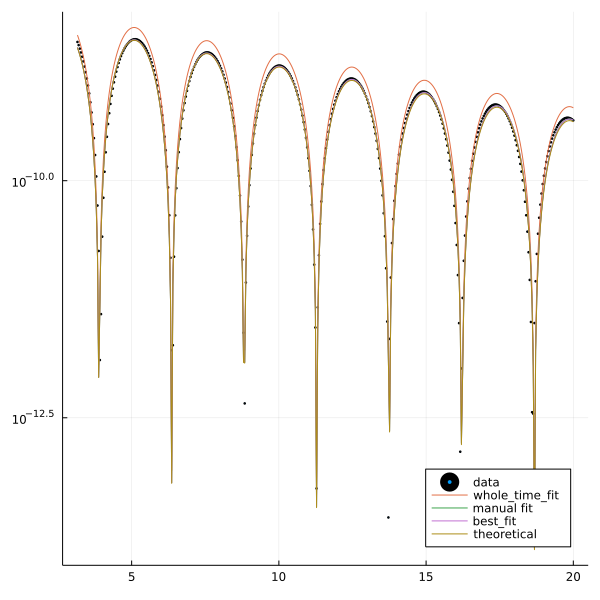

In [316]:

t_ss = t_series[80:end]
Plots.scatter(t_ss, Energy_E[80:end],label="data",markersize=1,yscale=:log10, legend=:bottomright)
plot!(t_ss,model_2(t_ss, fit_2.param), label="whole_time_fit")
plot!(t_ss,model_2(t_ss, p2),label="manual fit")
plot!(t_ss,model_2(t_ss, fit_2_c.param), label="best_fit")
plot!(t_ss,model_2(t_ss, [fit_2_c.param[1]; 1.275; -0.2500; 0.066]), label="theoretical")
#png("damped_fit_whole")